<a href="https://colab.research.google.com/github/heldigard/deeplearning-eval/blob/main/Image_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller Deep Learning: Image Classification**

**Integrantes**
* Eldigardo Camacho

Se va a utilizar la base de datos de **Natural Scene**, Estos son datos de imágenes de escenas naturales de todo el mundo. Las imágenes se han recopilado de la web y etiquetado manualmente. Las imágenes están divididas en 6 categorías. Estas son las categorías:
1. Buildings
2. Forest
3. Glacier
4. Mountain
5. Sea
6. Street 

Hay alrededor de 14k imágenes en Train, 3k en Test y 7k en Prediction.
En este cuaderno, se usa el proceso de implementación de CNN con Keras para clasificar imágenes.

Enlace de datos:
[Descargar la base de datos aquí]('https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data')

## **1. Cargar las librerias necesarias**

In [1]:
!pip install opencv-python

In [2]:
# Importar las librerias necesarias
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

## **2. Cargar los datos**

In [3]:
# Definir el tamaño de las imágenes
IMAGE_SIZE = (150, 150)

# Creando las etiquetas correspondientes a las categorias
nombres_clases = ["mountain", "street", "glacier", "buildings", "sea", "forest"]
etiquetas_clases = {nombre_clase: i for i, nombre_clase in enumerate(nombres_clases)}
etiquetas_clases

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

### **2.1 Cargar las imágenes**

In [4]:
def cargar_datos():
    """
    Cargar los datos:
        - 14,034 imágenes para entrenar la red.
        - 3,000 imágenes para evaluar la precisión con la que la red clasifica las imágenes.
    """

    datasets = ["./seg_train", "./seg_test"]
    salida = []

    # Iterar a través de los conjuntos de entrenamiento y prueba
    for dataset in datasets:

        imagenes = []
        etiquetas = []

        print(f"Cargando {dataset}")

        # Iterar a través de cada carpeta correspondiente a una categoría
        for carpeta in os.listdir(dataset):
            etiqueta = etiquetas_clases[carpeta]

            # Iterar a través de cada imagen en nuestra carpeta
            for archivo in tqdm(os.listdir(os.path.join(dataset, carpeta))):

                # Obtener la ruta de la imagen
                ruta_img = os.path.join(os.path.join(dataset, carpeta), archivo)

                # Abrir y redimensionar la imagen
                imagen = cv2.imread(ruta_img)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                imagen = cv2.resize(imagen, IMAGE_SIZE)

                # Añadir la imagen y su etiqueta correspondiente a la salida
                imagenes.append(imagen)
                etiquetas.append(etiqueta)

        imagenes = np.array(imagenes, dtype="float32")
        etiquetas = np.array(etiquetas, dtype="int32")

        salida.append((imagenes, etiquetas))

    return salida

In [5]:
(train_images, train_labels), (test_images, test_labels) = cargar_datos()

Cargando ./seg_train


100%|██████████| 2382/2382 [00:07<00:00, 320.22it/s]


Cargando ./seg_test


100%|██████████| 501/501 [00:01<00:00, 323.53it/s]


In [6]:
# Mezclar aleatoriamente los datos de entrenamiento
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## **3. Visualización de los datos**

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Imagenes de entrenamiento: {}".format(n_train))
print ("Imagenes de prueba: {}".format(n_test))
print ("Cada imagen es de tamaño: {}".format(IMAGE_SIZE))

Imagenes de entrenamiento: 14034
Imagenes de prueba: 3000
Cada imagen es de tamaño: (150, 150)


### **3.1 Visualización de Dataset**
Revisamos que tan distribuidas están las imágenes en cada carpeta.

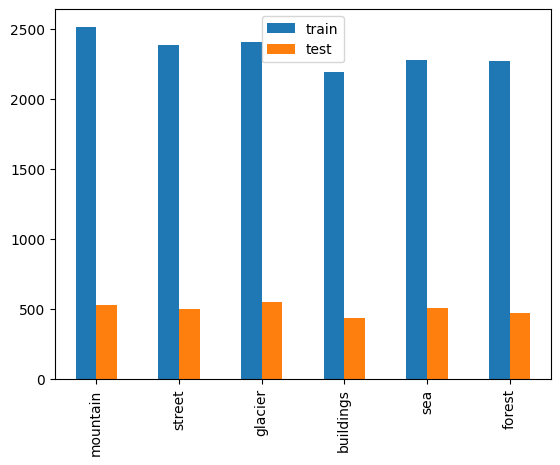

In [8]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame(
    {'train': train_counts, 'test': test_counts},
    index=nombres_clases
    ).plot.bar()
plt.show()

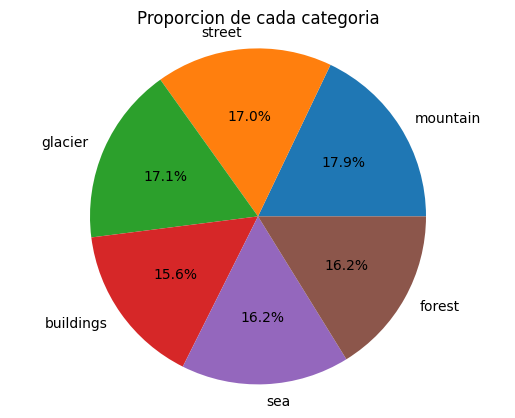

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) ,
        labels=nombres_clases,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporcion de cada categoria')
plt.show()

Vemos que las imagenes en cada categoria esta bastante balanceadas. Sin embargo, las imagenes de buildings son las que menos tenemos. Esto puede ser un problema, ya que la red podría aprender mal a clasificar las imagenes de buildings. Para solucionar esto, podemos aumentar el numero de imagenes de buildings usando data augmentation. Sin embargo, en este caso, no lo haremos.

## **4. Normalización de los datos**
Normalizar los datos para mejorar el rendimiento de la red. Para que queden en la escala de 0 a 1.

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## **5. Visualización de imagenes**

In [11]:
def mostrar_imagen_aleatoria(nombres_clases, images, labels):
    """
        Muestra una imagen aleatoria del arreglo de imágenes y su etiqueta correspondiente del arreglo de etiquetas.
    """
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Imagen #{} : '.format(index) + nombres_clases[labels[index]])
    plt.show()

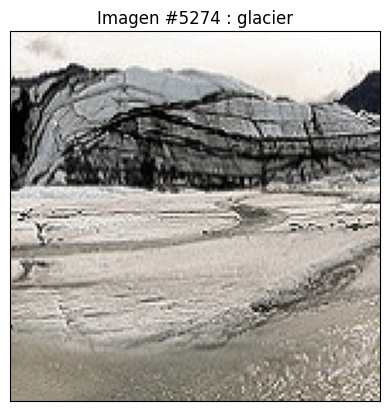

In [12]:
mostrar_imagen_aleatoria(nombres_clases, train_images, train_labels)

También podemos mostrar las primeras 25 imágenes del conjunto de entrenamiento directamente con un bucle para obtener una mejor vista previa.

In [13]:
def mostrar_ejemplos(nombres_clases, imagenes, etiquetas):
    """
        Muestra 25 imágenes de las imágenes con sus correspondientes etiquetas
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Algunos ejemplos de imágenes del conjunto de datos", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imagenes[i], cmap=plt.cm.binary)
        plt.xlabel(nombres_clases[etiquetas[i]])
    plt.show()


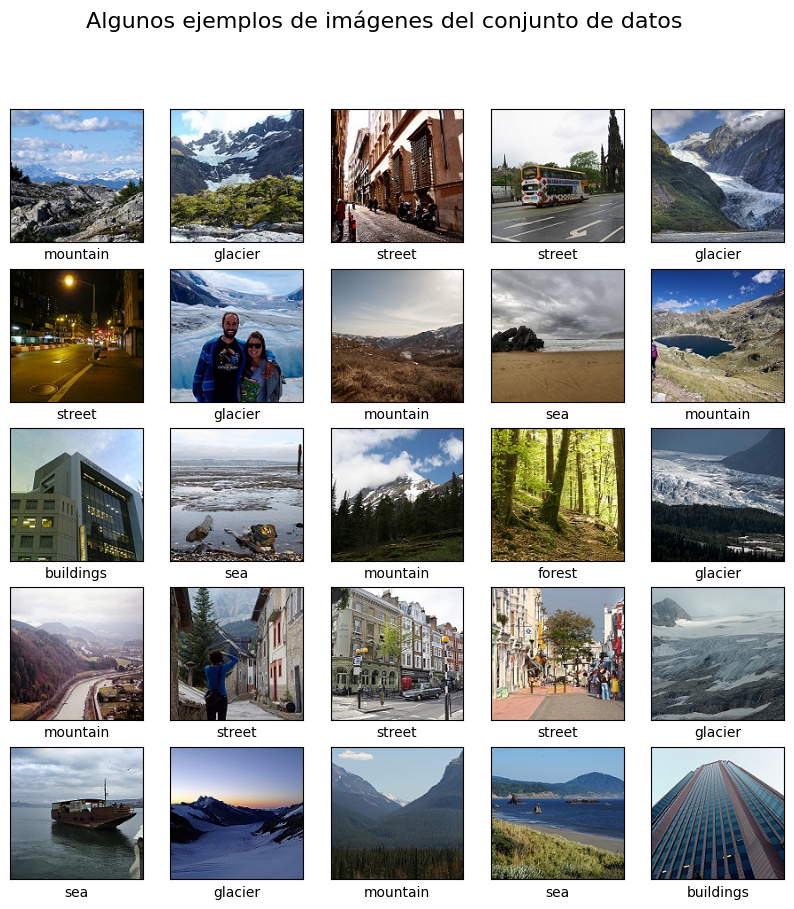

In [14]:
mostrar_ejemplos(nombres_clases, train_images, train_labels)

## **A. Crear el modelo con Keras**

Podemos construir un modelo sencillo compuesto por diferentes capas, como:

- Conv2D: (32 filtros de tamaño 3x3) Las características se extraerán de la imagen. 
- MaxPooling2D: las imágenes se reducirán a la mitad. 
- Flatten: transforma el formato de las imágenes desde una matriz bidimensional a una unidimensional de 150x150 píxeles con valores de color RGB. 
- ReLu: dado un valor x, devuelve max(x, 0). 
- Softmax: 6 neuronas, probabilidad de que la imagen pertenezca a una de las clases.
- Data Augmentation: Añadir capas de aumento de datos en el modelo puede ayudar a mejorar la generalización. Esto se hace antes de la capa de entrada.
- Dropout: Añadir capas de Dropout después de las capas densas puede ayudar a reducir el overfitting.
- Batch Normalization: Añadir capas de Batch Normalization después de las capas convolucionales y densas puede ayudar a mejorar la estabilidad y el rendimiento del modelo.

In [15]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast
# Hacer augmentación de datos
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomZoom(0.25),
])

In [18]:
# Se crea el modelo
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        data_augmentation,
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation="softmax"),
    ]
)

Luego, podemos compilarlo con algunos parámetros como:
- Optimizador: adam = RMSProp + Momentum. 
- Función de pérdida: categorical_crossentropy.
- Metricas: accuracy.

¿Qué es el momentum y el RMSProp? 
- Momentum: toma en cuenta la graduación pasada para tener una mejor actualización. 
- RMSProp: media ponderada exponencial de los cuadrados de las gradientes pasados. 
- Función de pérdida: utilizamos la pérdida categórica cruzada de Sparsidad para la clasificación, cada imagen pertenece a solo una clase.

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback para detener el entrenamiento temprano si no hay mejora en la pérdida de validación
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)


# Función para generar el nombre del archivo con las métricas
def create_model_checkpoint_path(epoch, logs):
    val_loss = logs["val_loss"]
    val_accuracy = logs["val_accuracy"]
    return os.path.join(
        save_dir,
        f"model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}.keras",
    )


# Callback para guardar el mejor modelo con las métricas en el nombre del archivo
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        self.filepath = create_model_checkpoint_path(epoch, logs)
        super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)


# Directorio donde se guardarán los modelos
save_dir = "model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Instancia del callback personalizado
custom_model_checkpoint = CustomModelCheckpoint(
    filepath=os.path.join(save_dir, "best_model.keras"),
    monitor="val_loss",
    save_best_only=True,
)

In [25]:
# Compilación del modelo
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


## **A.1. Entrenar el modelo**

Ajustamos el modelo a los datos del conjunto de entrenamiento. La red neuronal aprenderá por sí misma el patrón para clasificar cada categoría. El entrenamiento se hará en lotes de 128 imágenes, durante 20 epocas y se hará un conjunto de validación de 20%, para evaluar el rendimiento de la red.

In [26]:
# Entrenamiento del modelo
history = model.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping, custom_model_checkpoint],
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 353ms/step - accuracy: 0.8153 - loss: 0.5183 - val_accuracy: 0.7595 - val_loss: 0.6962
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 350ms/step - accuracy: 0.8408 - loss: 0.4516 - val_accuracy: 0.7855 - val_loss: 0.6372
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 349ms/step - accuracy: 0.8550 - loss: 0.4080 - val_accuracy: 0.7421 - val_loss: 0.8313
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 348ms/step - accuracy: 0.8630 - loss: 0.3798 - val_accuracy: 0.6680 - val_loss: 0.9809
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 350ms/step - accuracy: 0.8807 - loss: 0.3265 - val_accuracy: 0.8318 - val_loss: 0.4662
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 349ms/step - accuracy: 0.8868 - loss: 0.3208 - val_accuracy: 0.6676 - val_loss: 1.3508
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 349ms/step - accuracy: 0.9003 - loss: 0.2872 - val_accuracy: 0.8393 - val_loss: 0.4814
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 341ms/step - accuracy: 0.9015 - loss: 0

In [27]:
# Evaluamos la perdida y el acierto del modelo
def plot_acierto_perdida(history):
    """
        Gráfica del acierto y la pérdida durante el entrenamiento de la red neuronal.
    """
    fig = plt.figure(figsize=(10,5))

    # Gráfica del acierto
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label="acierto")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_acierto")
    plt.title("acierto de entrenamiento vs acierto de validación")
    plt.ylabel("acierto")
    plt.xlabel("épocas")
    plt.legend()

    # Gráfica de la función de pérdida
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label="pérdida")
    plt.plot(history.history['val_loss'], 'ro--', label="val_pérdida")
    plt.title("pérdida de entrenamiento vs pérdida de validación")
    plt.ylabel("pérdida")
    plt.xlabel("épocas")

    plt.legend()
    plt.show()


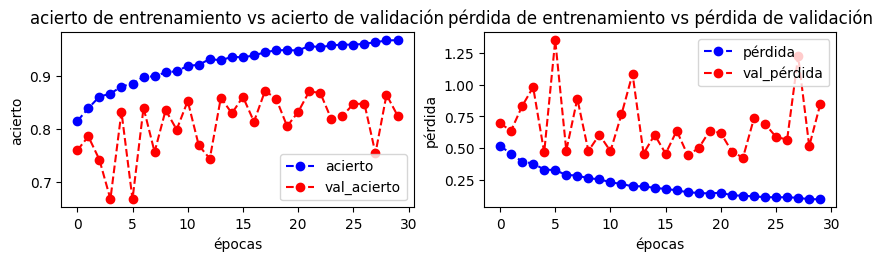

In [28]:
plot_acierto_perdida(history)

In [29]:
# Guardar el modelo entrenado
model.save("model_Natural_images_CNN.keras")

In [15]:
from tensorflow.keras.models import load_model

# Ruta al archivo del modelo guardado
model_path = "./model_Natural_images_CNN.keras"

# Cargar el modelo
model = load_model(model_path)

Evaluamos el modelo con los datos de prueba.

In [17]:
test_loss = model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8610 - loss: 0.4386


El modelo mejorado tiene una precisión del 86% en el conjunto de prueba. 
Ahora ¡Veamos cómo está funcionando el clasificador en algunas imágenes aleatorias!

## **A.2. Predicción**

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


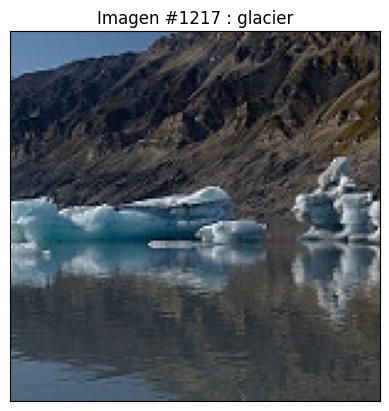

In [18]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

mostrar_imagen_aleatoria(nombres_clases, test_images, pred_labels)

## **A.3. Analisis del Error**

Vamos a ver algunas de las imágenes mal etiquetadas.

In [26]:
def print_mislabeled_images(nombres_clases, test_images, test_labels, pred_labels):
    """
        Imprime 25 ejemplos de imágenes mal etiquetadas por el clasificador, es decir, cuando test_labels != pred_labels
    """
    BOO = (test_labels  == pred_labels)
    mislabeled_indices  = np.where(BOO == 0)
    mislabeled_images  = test_images[mislabeled_indices]
    mislabeled_labels  = pred_labels[mislabeled_indices]

    titulo = "Algunos ejemplos de imágenes mal etiquetadas por el clasificador:"
    print(titulo)
    mostrar_ejemplos(nombres_clases, mislabeled_images, mislabeled_labels)


Algunos ejemplos de imágenes mal etiquetadas por el clasificador:


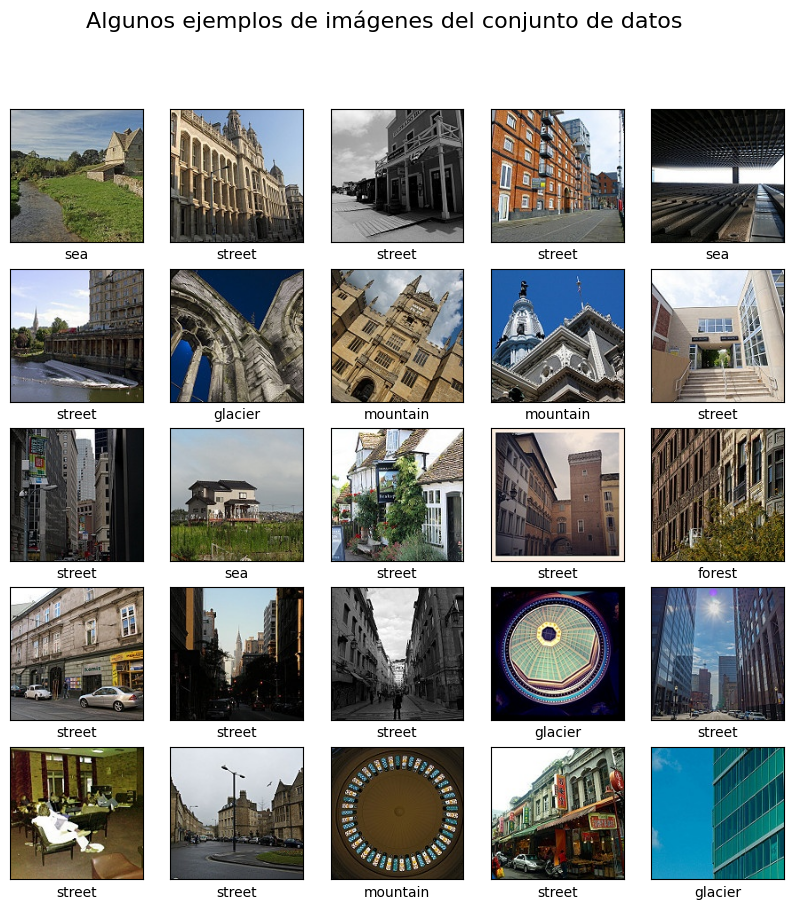

In [27]:
print_mislabeled_images(nombres_clases, test_images, test_labels, pred_labels)

## A.3.1. Matriz de confusión

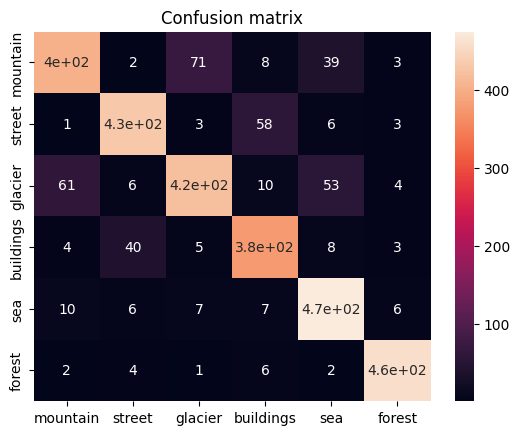

In [28]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=nombres_clases,
           yticklabels=nombres_clases, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [29]:
CM

array([[402,   2,  71,   8,  39,   3],
       [  1, 430,   3,  58,   6,   3],
       [ 61,   6, 419,  10,  53,   4],
       [  4,  40,   5, 377,   8,   3],
       [ 10,   6,   7,   7, 474,   6],
       [  2,   4,   1,   6,   2, 459]], dtype=int64)

# A.4 Conclusiones Matriz de Confusión: 

## Desempeño General

* **Buena precisión en la mayoría de las clases:** Los valores diagonales (correcciones) son generalmente altos, lo que sugiere que el modelo está clasificando correctamente la mayoría de las imágenes.
* **Confusión entre clases similares:** Hay una cierta confusión entre clases visualmente similares. Por ejemplo, "montañas" y "glaciares", o "edificios" y "calles". Esto es esperable y puede ser difícil de evitar incluso para modelos avanzados.

## Errores Comunes:
- **‘Mountain’ y ‘Glacier’**: 71 imágenes de ‘Mountain’ clasificadas incorrectamente como ‘Glacier’.
- **‘Street’ y ‘Buildings’**: 58 imágenes de ‘Street’ clasificadas incorrectamente como ‘Buildings’.
- **‘Glacier’ y ‘Sea’**: 53 imágenes de ‘Glacier’ clasificadas incorrectamente como ‘Sea’.
- **‘Buildings’ y ‘Street’**: 40 imágenes de ‘Buildings’ clasificadas incorrectamente como ‘Street’.

## Categorías con Mejor Rendimiento:
- **‘Forest’**: Tiene el mejor rendimiento por tener pocos errores.

## Categorías con Peor Rendimiento:
- **‘Mountain’**: Tiene un número considerable de errores, especialmente con ‘Glacier’ (71 errores) y ‘Sea’ (39 errores).
- **‘Glacier’**: Muestra confusiones notables con ‘Mountain’ (61 errores) y ‘Sea’ (53 errores).


* **"Montañas":** La mayor confusión es con "calles". Esto podría deberse a la presencia de carreteras en imágenes de montañas o a fondos urbanos en imágenes de montañas lejanas.
* **"Calles":** La confusión principal es con "edificios", lo cual es lógico dado que ambos entornos urbanos suelen contener elementos similares.
* **"Glaciares":** La confusión es más dispersa, pero hay una cantidad significativa de imágenes clasificadas como "montañas". Esto podría deberse a la similitud visual entre algunas montañas nevadas y glaciares.
* **"Edificios":** La confusión principal es con "calles", como se mencionó anteriormente.
* **"Mar":** El modelo parece tener un buen desempeño en la clasificación de imágenes de mar.
* **"Bosque":** También muestra un buen desempeño en la clasificación de bosques.

